In [ ]:
# import necessary libraries
from pyomo.environ import *
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from itertools import permutations
import random
from ortools.constraint_solver import routing_enums_pb2, pywrapcp

In [ ]:
# get the data from given files
coords_An32k5 = [
    (82,76), (96,44), (50,5), (49,8), (13,7), (29,89), (58,30),
    (84,39), (14,24), (2,39), (3,82), (5,10), (98,52), (84,25),
    (61,59), (1,65), (88,51), (91,2), (19,32), (93,3), (50,93),
    (98,14), (5,42), (42,9), (61,62), (9,97), (80,55), (57,69),
    (23,15), (20,70), (85,60), (98,5)
]
demands_An32k5 = [0,19,21,6,19,7,12,16,6,16,8,14,21,16,3,22,18,19,1,
            24,8,12,4,8,24,24,2,20,15,2,14,9]

coords_An80k10 = [
    (92,92), (88,58), (70,6), (57,59), (0,98), (61,38), (65,22),
    (91,52), (59,2), (3,54), (95,38), (80,28), (66,42), (79,74),
    (99,25), (20,43), (40,3), (50,42), (97,0), (21,19), (36,21),
    (100,61), (11,85), (69,35), (69,22), (29,35), (14,9), (50,33),
    (89,17), (57,44), (60,25), (48,42), (17,93), (21,50), (77,18),
    (2,4), (63,83), (68,6), (41,95), (48,54), (98,73), (26,38),
    (69,76), (40,1), (65,41), (14,86), (32,39), (14,24), (96,5),
    (82,98), (23,85), (63,69), (87,19), (56,75), (15,63), (10,45),
    (7,30), (31,11), (36,93), (50,31), (49,52), (39,10), (76,40),
    (83,34), (33,51), (0,15), (52,82), (52,82), (46,6), (3,26),
    (46,80), (94,30), (26,76), (75,92), (57,51), (34,21), (28,80),
    (59,66), (51,16), (87,11)
]
demands_An80k10 = [0,24,22,23,5,11,23,26,9,23,9,14,16,12,2,2,6,20,26,12,
            15,13,26,17,7,12,4,4,20,10,9,2,9,1,2,2,12,14,23,21,13,
            13,23,3,6,23,11,2,7,13,10,3,6,13,2,14,7,21,7,22,13,22,
            18,22,6,2,11,5,9,9,5,12,2,12,19,6,14,2,2,24]

# Question 1

In [52]:
# Data: First 11 nodes from A-n32-k5
coordinates = [
    (82, 76), (96, 44), (50, 5), (49, 8), (13, 7),
    (29, 89), (58, 30), (84, 39), (14, 24), (2, 39), (3, 82)
]
demands = [0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8]  # Depot demand=0
Q = 100  # Vehicle capacity
num_vehicles = 10
N = len(coordinates)
V = range(N)
C = range(1, N)  # Customer nodes (excluding depot)

# Compute distance matrix
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

distance = np.zeros((N, N))
for i in V:
    for j in V:
        if i != j:
            distance[i][j] = euclidean_distance(coordinates[i], coordinates[j])

# Create model
model = ConcreteModel()

# Decision Variables
model.x = Var(V, V, within=Binary)  # x_ij: Binary variable for vehicle travel
model.u = Var(V, within=NonNegativeReals)  # u_i: Cumulative demand at node i

# Objective Function: Minimize total travel distance
model.obj = Objective(
    expr=sum(distance[i][j] * model.x[i, j] for i in V for j in V if i != j),sense=minimize)

# Constraints
# 1. Depot Flow: At least one vehicle must leave the depot
model.leave_depot = Constraint(expr=sum(model.x[0, j] for j in C) >= 1)

# 2. Each customer is visited exactly once
model.visit_once = ConstraintList()
for k in C:
    model.visit_once.add(sum(model.x[i, k] for i in V if i != k) == 1)
    model.visit_once.add(sum(model.x[k, j] for j in V if j != k) == 1)

# 3. Capacity Constraints
model.capacity = ConstraintList()
for i in C:
    for j in C:
        if i != j:
            model.capacity.add(model.u[j] >= model.u[i] + demands[j] - Q * (1 - model.x[i, j]))

# 4. Subtour Elimination (MTZ constraints)
model.subtour = ConstraintList()
for i in C:
    model.subtour.add(model.u[i] >= demands[i])  # Lower bound on u_i
    model.subtour.add(model.u[i] <= Q)  # Upper bound on u_i

# Solve
solver = SolverFactory('gurobi').solve(model)

# Print Solution
for i in V:
    for j in V:
        if i != j and model.x[i, j].value > 0.5:
            print(f"Vehicle travels from {i} to {j}")
print("Total Distance:", model.obj())

Vehicle travels from 0 to 1
Vehicle travels from 0 to 5
Vehicle travels from 1 to 7
Vehicle travels from 2 to 3
Vehicle travels from 3 to 6
Vehicle travels from 4 to 2
Vehicle travels from 5 to 10
Vehicle travels from 6 to 0
Vehicle travels from 7 to 0
Vehicle travels from 8 to 4
Vehicle travels from 9 to 8
Vehicle travels from 10 to 9
Total Distance: 361.60028508789037


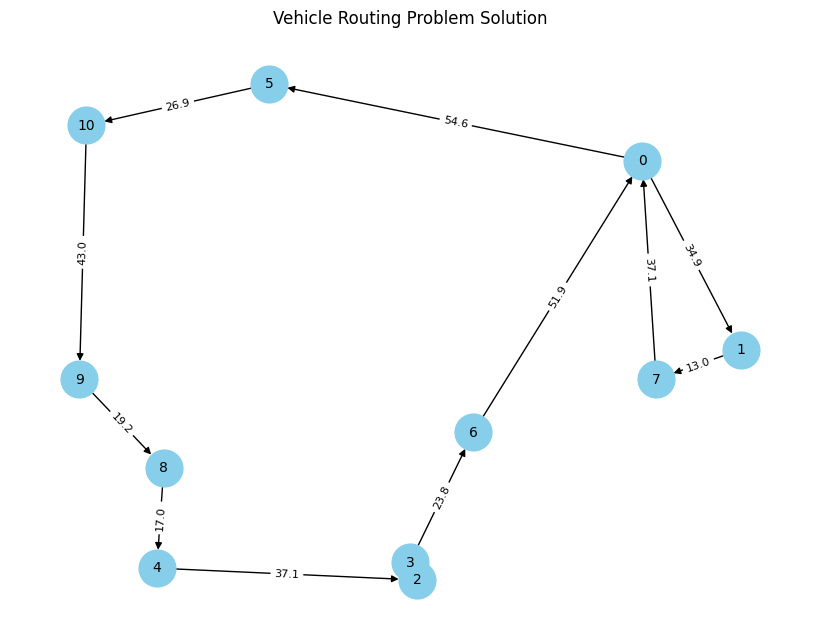

In [ ]:
import networkx as nx
# Extract solution from Pyomo model
routes = []
for i in V:
    for j in V:
        if i != j and model.x[i, j].value > 0.5:
            routes.append((i, j))
# Create graph
G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(routes)
# Node positions
pos = {i: coordinates[i] for i in V}
# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='black', node_size=700, font_size=10, arrows=True)
# Annotate edges with distances
edge_labels = {(i, j): f"{distance[i][j]:.1f}" for (i, j) in routes}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
# Title
plt.title("Vehicle Routing Problem Solution")
plt.show()


# Question 2: Time Complexity Analysis

n=11: Exact=0.09s, SA=0.03s
n=12: Exact=0.13s, SA=0.04s
n=13: Exact=0.36s, SA=0.04s


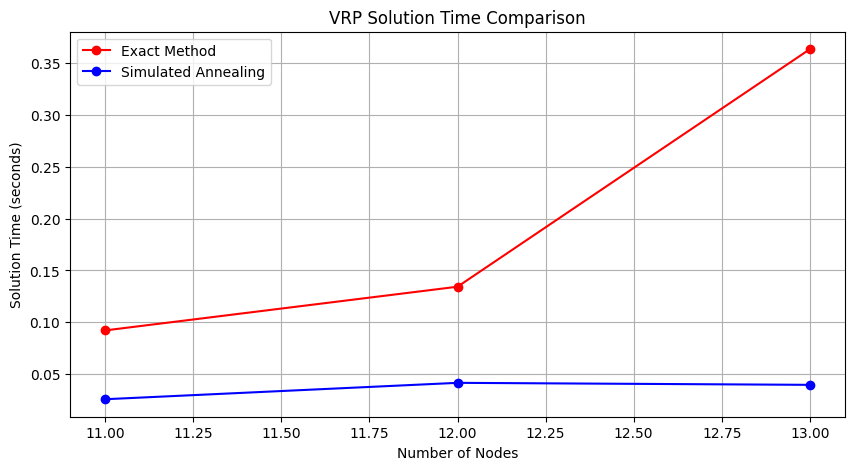

In [54]:
# ========== Data Preparation ==========
def load_data(nodes):
    full_coords = coords_An32k5
    full_demands = demands_An32k5
    return full_coords[:nodes], full_demands[:nodes]

# ========== Exact Method (Pyomo) ==========
def solve_exact(nodes):
    coords, demands = load_data(nodes)
    capacity = 100
    n = len(coords)
    
    # Distance matrix
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i,j] = np.hypot(coords[i][0]-coords[j][0], coords[i][1]-coords[j][1])
    
    # Pyomo model
    model = ConcreteModel()
    model.N = RangeSet(0, n-1)
    
    # Variables
    model.x = Var(model.N, model.N, within=Binary)
    model.u = Var(model.N, within=NonNegativeReals)
    
    # Objective
    model.obj = Objective(expr=sum(dist[i,j]*model.x[i,j] 
                              for i in model.N for j in model.N), 
                              sense=minimize)
    
    # Constraints
    # 1. Customer visits
    def customer_rule(m, k):
        if k == 0: return Constraint.Skip
        return sum(m.x[i,k] for i in m.N if i != k) == 1
    model.cust_constr = Constraint(model.N, rule=customer_rule)
    
    # 2. Depot flow
    model.depot_out = Constraint(expr=sum(model.x[0,j] for j in model.N if j != 0) >= 1)
    model.depot_in = Constraint(expr=sum(model.x[i,0] for i in model.N if i != 0) >= 1)
    
    # 3. MTZ constraints
    M = capacity + max(demands)
    def mtz_rule(m, i, j):
        if i == j or i == 0 or j == 0: return Constraint.Skip
        return m.u[j] >= m.u[i] + demands[j] - M*(1 - m.x[i,j])
    model.mtz = Constraint(model.N, model.N, rule=mtz_rule)
    
    # 4. Capacity bounds
    def capacity_rule(m, i):
        if i == 0: return Constraint.Skip
        return (demands[i], m.u[i], capacity)
    model.cap_constr =Constraint(model.N, rule=capacity_rule)
    
    # Solve
    solver =SolverFactory('gurobi')
    start = time.time()
    results = solver.solve(model)
    return time.time() - start

# ========== Simulated Annealing ==========
def simulated_annealing(nodes):
    coords, demands = load_data(nodes)
    capacity = 100
    n = len(coords)
    
    def calculate_cost(solution):
        total = 0
        for route in solution:
            for i in range(len(route)-1):
                total += np.hypot(coords[route[i]][0]-coords[route[i+1]][0],
                                 coords[route[i]][1]-coords[route[i+1]][1])
        return total
    
    def generate_neighbor(current):
        new = [r.copy() for r in current]
        r1, r2 = random.sample(range(len(new)), 2)
        if len(new[r1]) > 2 and len(new[r2]) > 2:
            i = random.randint(1, len(new[r1])-2)
            j = random.randint(1, len(new[r2])-2)
            new[r1][i], new[r2][j] = new[r2][j], new[r1][i]
        return new
    
    # Initial solution
    current = [[0, i, 0] for i in range(1, n)]  # Each customer in own vehicle
    current_cost = calculate_cost(current)
    
    T = 1000
    alpha = 0.95
    start = time.time()
    
    for _ in range(1000):
        neighbor = generate_neighbor(current)
        neighbor_cost = calculate_cost(neighbor)
        
        if neighbor_cost < current_cost or random.random() < np.exp((current_cost - neighbor_cost)/T):
            current = neighbor
            current_cost = neighbor_cost
        
        T *= alpha
    
    return time.time() - start

# ========== Execution Block ==========
node_counts = [11, 12, 13]
exact_times = []
sa_times = []

for n in node_counts:
    try:
        # Run exact method
        exact_time = solve_exact(n)
        exact_times.append(exact_time)
    except Exception as e:
        print(f"Exact method failed for n={n}: {str(e)}")
        exact_times.append(np.nan)  # Use NaN as placeholder

    try:
        # Run simulated annealing
        sa_time = simulated_annealing(n)
        sa_times.append(sa_time)
    except Exception as e:
        print(f"SA failed for n={n}: {str(e)}")
        sa_times.append(np.nan)  # Use NaN as placeholder

    print(f"n={n}: Exact={exact_times[-1]:.2f}s, SA={sa_times[-1]:.2f}s")

# Filter out failed runs
valid_indices = ~np.isnan(exact_times) & ~np.isnan(sa_times)
filtered_counts = np.array(node_counts)[valid_indices]
filtered_exact = np.array(exact_times)[valid_indices]
filtered_sa = np.array(sa_times)[valid_indices]

# ========== Plotting ==========
if len(filtered_counts) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_counts, filtered_exact, 'ro-', label='Exact Method')
    plt.plot(filtered_counts, filtered_sa, 'bo-', label='Simulated Annealing')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Solution Time (seconds)')
    plt.title('VRP Solution Time Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data to plot!")

# Question 3

Running for A-n32-k5:
T0=100: Cost=1054.21, Gap=34.47%, Time=0.04s
T0=500: Cost=1004.45, Gap=28.12%, Time=0.02s
T0=1000: Cost=1120.38, Gap=42.91%, Time=0.02s
T0=1500: Cost=1058.06, Gap=34.96%, Time=0.02s
T0=2000: Cost=1024.02, Gap=30.62%, Time=0.02s


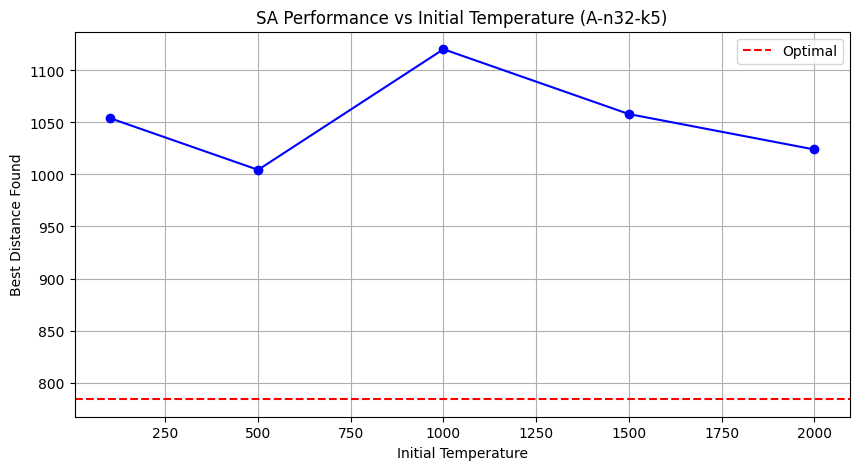


Running for A-n80-k10:
T0=100: Cost=2755.04, Gap=56.27%, Time=0.04s
T0=500: Cost=3056.22, Gap=73.35%, Time=0.02s
T0=1000: Cost=2835.38, Gap=60.83%, Time=0.04s
T0=1500: Cost=2804.68, Gap=59.09%, Time=0.03s
T0=2000: Cost=2770.51, Gap=57.15%, Time=0.03s


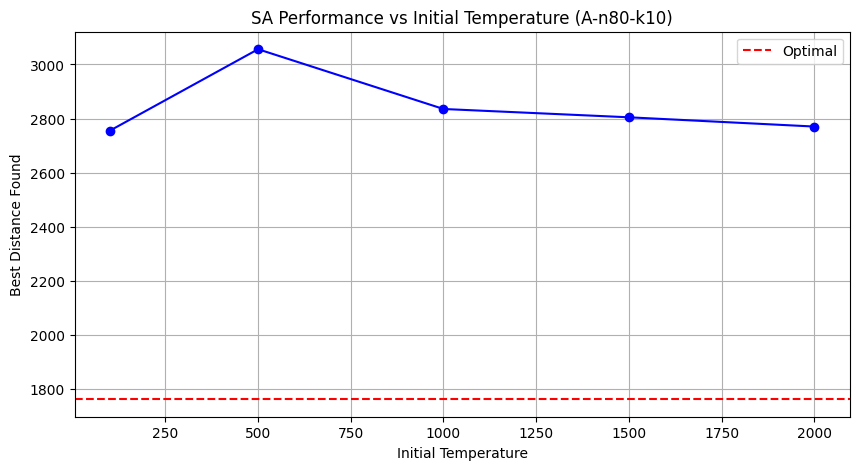

In [ ]:
# ========== Data Loading ==========
def load_vrp_data(dataset):
    if dataset == "A-n32-k5":
        # From A-n32-k5.pdf content
        coords = coords_An32k5
        demands = demands_An32k5
        optimal = 784
    else:  # A-n80-k10
        coords = coords_An80k10
        demands = demands_An80k10
        optimal = 1763
    
    capacity = 100
    return np.array(coords), np.array(demands), capacity, optimal

# ========== Simulated Annealing Core ==========
class VRP_SA:
    def __init__(self, coords, demands, capacity, optimal):
        self.coords = coords
        self.demands = demands
        self.capacity = capacity
        self.optimal = optimal
        self.dist_matrix = self._create_distance_matrix()
        
    def _create_distance_matrix(self):
        n = len(self.coords)
        matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                matrix[i][j] = np.linalg.norm(self.coords[i] - self.coords[j])
        return matrix
    
    def _generate_initial(self):
        route = [0]  # Depot index
        current_load = 0
        customers = list(range(1, len(self.demands)))
        np.random.shuffle(customers)
        
        for c in customers:
            if current_load + self.demands[c] > self.capacity:
                route.append(0)
                yield route
                route = [0, c]
                current_load = self.demands[c]
            else:
                route.append(c)
                current_load += self.demands[c]
        route.append(0)
        yield route
        
    def _calculate_cost(self, solution):
        total = 0
        for route in solution:
            for i in range(len(route)-1):
                total += self.dist_matrix[route[i]][route[i+1]]
        return total
    
    def _generate_neighbor(self, current):
        new = [r.copy() for r in current]
        if len(new) < 2: return new
        
        r1, r2 = np.random.choice(len(new), 2, replace=False)
        if len(new[r1]) > 2 and len(new[r2]) > 2:
            i = np.random.randint(1, len(new[r1])-1)
            j = np.random.randint(1, len(new[r2])-1)
            new[r1][i], new[r2][j] = new[r2][j], new[r1][i]
        return new
    
    def run(self, T_initial=1000, alpha=0.95, iterations=1000):
        current = list(self._generate_initial())
        current_cost = self._calculate_cost(current)
        best_cost = current_cost
        start_time = time.time()
        
        T = T_initial
        for _ in range(iterations):
            neighbor = self._generate_neighbor(current)
            neighbor_cost = self._calculate_cost(neighbor)
            
            delta = neighbor_cost - current_cost
            if delta < 0 or math.exp(-delta/T) > np.random.random():
                current = neighbor
                current_cost = neighbor_cost
                if current_cost < best_cost:
                    best_cost = current_cost
            
            T *= alpha
        
        time_elapsed = time.time() - start_time
        gap = (best_cost - self.optimal)/self.optimal * 100
        return best_cost, gap, time_elapsed

# ========== Experiment Execution ==========
def run_temperature_experiment(dataset_name):
    # Load dataset
    coords, demands, capacity, optimal = load_vrp_data(dataset_name)
    sa = VRP_SA(coords, demands, capacity, optimal)
    
    # Temperature parameters
    temperatures = [100, 500, 1000, 1500, 2000]
    results = []
    
    for T0 in temperatures:
        best_cost, gap, time = sa.run(T_initial=T0)
        results.append({
            'T0': T0,
            'best_cost': best_cost,
            'gap': gap,
            'time': time
        })
        print(f"T0={T0}: Cost={best_cost:.2f}, Gap={gap:.2f}%, Time={time:.2f}s")
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot([r['T0'] for r in results], [r['best_cost'] for r in results], 'bo-')
    plt.axhline(optimal, color='r', linestyle='--', label='Optimal')
    plt.xlabel('Initial Temperature')
    plt.ylabel('Best Distance Found')
    plt.title(f'SA Performance vs Initial Temperature ({dataset_name})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

# ========== Run Experiments ==========
print("Running for A-n32-k5:")
results_32 = run_temperature_experiment("A-n32-k5")
print("\nRunning for A-n80-k10:")
results_80 = run_temperature_experiment("A-n80-k10")


# Question 4

Best Solution: [[7, 19, 18, 16, 24, 30], [11, 4, 17, 29, 21, 2], [7, 13, 19, 1, 12], [16, 20, 14, 2, 26, 11, 27], [23, 25]]
Best Cost: 1432.60


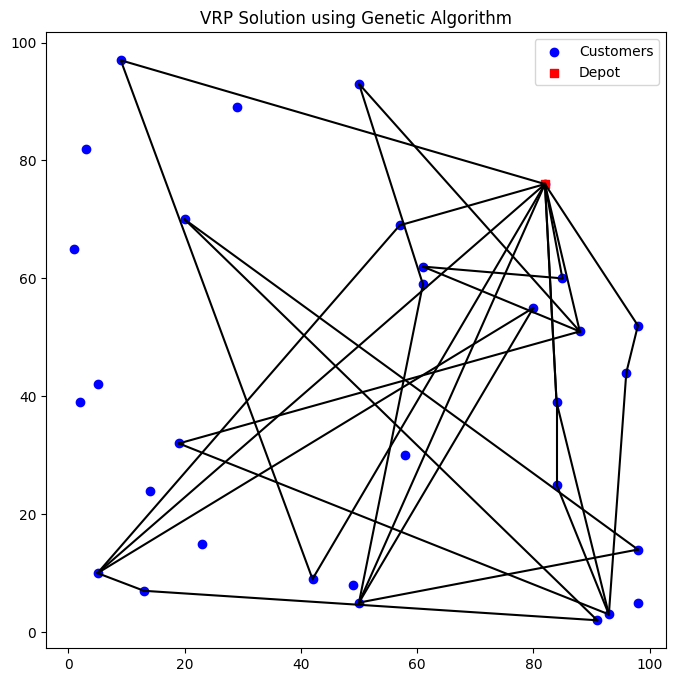

In [59]:
# ========== Load Dataset ==========
def load_vrp_data(dataset):
    if dataset == "A-n32-k5":
        coords = coords_An32k5
        demands = demands_An32k5
        capacity = 100
        num_vehicles = 5
    else:
        raise ValueError("Dataset not supported.")
    
    return np.array(coords), np.array(demands), capacity, num_vehicles

# ========== Distance Matrix ==========
def compute_distance_matrix(coords):
    n = len(coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i][j] = np.linalg.norm(np.array(coords[i]) - np.array(coords[j]))
    return dist_matrix

# ========== Genetic Algorithm for VRP ==========
class GeneticVRP:
    def __init__(self, coords, demands, capacity, num_vehicles, pop_size=50, generations=200):
        self.coords = coords
        self.demands = demands
        self.capacity = capacity
        self.num_vehicles = num_vehicles
        self.dist_matrix = compute_distance_matrix(coords)
        self.pop_size = pop_size
        self.generations = generations

    def generate_initial_population(self):
        population = []
        customers = list(range(1, len(self.demands)))
        for _ in range(self.pop_size):
            random.shuffle(customers)
            routes, load = [[]], 0
            for c in customers:
                if load + self.demands[c] > self.capacity:
                    routes.append([])
                    load = 0
                routes[-1].append(c)
                load += self.demands[c]
            population.append(routes)
        return population

    def fitness(self, solution):
        total_dist = 0
        for route in solution:
            route = [0] + route + [0]
            for i in range(len(route)-1):
                total_dist += self.dist_matrix[route[i]][route[i+1]]
        return total_dist

    def tournament_selection(self, population, k=5):
        selected = random.sample(population, k)
        return min(selected, key=self.fitness)

    def crossover(self, parent1, parent2):
        child1, child2 = parent1.copy(), parent2.copy()
        if random.random() < 0.8:  # 80% chance to crossover
            cut = len(parent1) // 2
            child1[:cut], child2[:cut] = parent2[:cut], parent1[:cut]
        return child1, child2

    def mutate(self, solution):
        if random.random() < 0.2:  # 20% mutation chance
            route_idx = random.randint(0, len(solution)-1)
            if len(solution[route_idx]) > 1:
                i, j = random.sample(range(len(solution[route_idx])), 2)
                solution[route_idx][i], solution[route_idx][j] = solution[route_idx][j], solution[route_idx][i]
        return solution

    def evolve(self):
        population = self.generate_initial_population()
        best_solution = min(population, key=self.fitness)
        best_cost = self.fitness(best_solution)

        for _ in range(self.generations):
            new_population = []
            for _ in range(self.pop_size // 2):
                parent1 = self.tournament_selection(population)
                parent2 = self.tournament_selection(population)
                child1, child2 = self.crossover(parent1, parent2)
                new_population.extend([self.mutate(child1), self.mutate(child2)])
            
            population = sorted(new_population, key=self.fitness)[:self.pop_size]
            current_best = min(population, key=self.fitness)
            if self.fitness(current_best) < best_cost:
                best_solution, best_cost = current_best, self.fitness(current_best)

        return best_solution, best_cost

# ========== Run Genetic Algorithm on Dataset ==========
dataset = "A-n32-k5"
coords, demands, capacity, num_vehicles = load_vrp_data(dataset)
ga_solver = GeneticVRP(coords, demands, capacity, num_vehicles)

best_solution, best_cost = ga_solver.evolve()
print(f"Best Solution: {best_solution}")
print(f"Best Cost: {best_cost:.2f}")

# ========== Plot Solution ==========
def plot_solution(coords, solution):
    plt.figure(figsize=(8, 8))
    plt.scatter(coords[:,0], coords[:,1], c='blue', label="Customers")
    plt.scatter(coords[0,0], coords[0,1], c='red', marker='s', label="Depot")
    
    for route in solution:
        route = [0] + route + [0]
        for i in range(len(route)-1):
            plt.plot([coords[route[i],0], coords[route[i+1],0]], 
                     [coords[route[i],1], coords[route[i+1],1]], 'k-')

    plt.legend()
    plt.title("VRP Solution using Genetic Algorithm")
    plt.show()

plot_solution(coords, best_solution)


# Question 5

In [ ]:
# ========== Load VRP Data ==========
def load_vrp_data(dataset):
   
    if dataset == "A-n32-k5":
        coords = coords_An32k5
        demands = demands_An32k5
        optimal = 784
    else:  # A-n80-k10
        coords = coords_An80k10
        demands = demands_An80k10
        optimal = 1763
    
    capacity = 100
    return np.array(coords), np.array(demands), capacity, optimal

# ========== OR-Tools VRP Solver ==========
def solve_vrp_with_or_tools(dataset_name):
    """Solve VRP using Google OR-Tools"""
    coords, demands, capacity, optimal = load_vrp_data(dataset_name)
    num_locations = len(coords)
    num_vehicles = 5 if dataset_name == "A-n32-k5" else 10
    depot = 0

    # Distance matrix
    def compute_distance_matrix():
        """Computes Euclidean distance between locations"""
        matrix = np.zeros((num_locations, num_locations))
        for i in range(num_locations):
            for j in range(num_locations):
                matrix[i][j] = np.linalg.norm(coords[i] - coords[j])
        return matrix.astype(int)

    distance_matrix = compute_distance_matrix()

    # OR-Tools Data Model
    data = {
        'distance_matrix': distance_matrix,
        'demands': demands.tolist(),
        'vehicle_capacities': [capacity] * num_vehicles,
        'num_vehicles': num_vehicles,
        'depot': depot,
    }

    # OR-Tools Routing Model
    manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)
    routing = pywrapcp.RoutingModel(manager)

    # Distance Callback
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Demand Callback
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index, 0, data['vehicle_capacities'], True, "Capacity"
    )

    # Search Parameters
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.seconds = 10

    # Solve VRP
    solution = routing.SolveWithParameters(search_params)

    # Print Solution
    if solution:
        total_distance = 0
        for vehicle_id in range(num_vehicles):
            index = routing.Start(vehicle_id)
            route_distance = 0
            route = []
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route.append(node_index)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            route.append(manager.IndexToNode(index))
            total_distance += route_distance
            print(f"Vehicle {vehicle_id}: {route} | Distance: {route_distance}")
        
        print(f"Total Cost (Distance): {total_distance}")
        print(f"Optimal Solution (Benchmark): {optimal}")
        print(f"Gap: {(total_distance - optimal) / optimal * 100:.2f}%")
    else:
        print("No solution found.")

# ========== Run OR-Tools on Both Datasets ==========
print("\nSolving A-n32-k5 with OR-Tools...")
solve_vrp_with_or_tools("A-n32-k5")

print("\nSolving A-n80-k10 with OR-Tools...")
solve_vrp_with_or_tools("A-n80-k10")



Solving A-n32-k5 with OR-Tools...
Vehicle 0: [0, 24, 27, 0] | Distance: 58
Vehicle 1: [0, 3, 2, 23, 28, 4, 11, 8, 18, 14, 0] | Distance: 226
Vehicle 2: [0, 26, 13, 21, 31, 19, 17, 6, 0] | Distance: 178
Vehicle 3: [0, 29, 22, 9, 15, 10, 25, 5, 20, 0] | Distance: 234
Vehicle 4: [0, 12, 1, 7, 16, 30, 0] | Distance: 86
Total Cost (Distance): 782
Optimal Solution (Benchmark): 784
Gap: -0.26%

Solving A-n80-k10 with OR-Tools...
Vehicle 0: [0, 14, 48, 18, 79, 28, 52, 71, 0] | Distance: 189
Vehicle 1: [0, 30, 78, 68, 43, 16, 61, 20, 59, 27, 64, 77, 0] | Distance: 239
Vehicle 2: [0, 62, 23, 12, 44, 5, 29, 13, 0] | Distance: 141
Vehicle 3: [0, 31, 75, 57, 26, 35, 65, 69, 56, 55, 9, 50, 0] | Distance: 289
Vehicle 4: [0, 74, 17, 60, 39, 3, 51, 0] | Distance: 134
Vehicle 5: [0, 42, 36, 73, 49, 0] | Distance: 72
Vehicle 6: [0, 24, 6, 8, 37, 2, 34, 11, 10, 0] | Distance: 203
Vehicle 7: [0, 67, 66, 76, 72, 54, 33, 15, 47, 19, 25, 41, 46, 53, 0] | Distance: 243
Vehicle 8: [0, 40, 21, 7, 63, 1, 0] | Di